In [1]:
using Pipe
using DataFrames
# using StatsPlots
using CSV
# using RollingFunctions
using Query
# using GLMakie

using JSON
using DataFrames
using Dates
using Colors
# using ColorSchemes
using Indicators

import Colors
using Plots
using Interact
using Statistics
using StatsBase

include("utils.jl")

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-3188147792716788074\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-13854899419047812607\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-3188147792716788074\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

calc_wavelet (generic function with 1 method)

In [2]:
json_data_folder = "../user_data/data/binance"
json_filename = "BTC_USDT-1m.json"
json_filepath = "$json_data_folder/$json_filename"
f = open(json_filepath, "r")
json_data = JSON.parse(f)
close(f)

dfa = DataFrame(unix_time = Int64[], open=Float64[], high=Float64[], low=Float64[], close=Float64[], volume=Float64[])
for r in json_data push!(dfa, r) end
dfa.unix_time .= dfa.unix_time ./1000
# dfa.time .= unix2datetime.(dfa.unix_time)

insertcols!(dfa, :time => unix2datetime.(dfa.unix_time))
nrow(dfa)

232834

In [3]:
last(dfa)

,unix_time,open,high,low,close,volume,time
,Int64,Float64,Float64,Float64,Float64,Float64,DateTime
232834,1623465360,35779.7,35788.6,35737.2,35788.5,41.5506,2021-06-12T02:36:00


In [4]:
start_date = DateTime(2021, 6, 1)
end_date = DateTime(2021, 6, 12)
vdf = dfa[(dfa.time .>= start_date) .& (dfa.time .<= end_date) , :]
ut, tt, hh, ll, cc, oo = vdf.unix_time, vdf.time, vdf.high, vdf.low, vdf.close, vdf.open
length(tt)

15841

In [33]:
function backtest(p; shouldEnter = (args...) -> false, getEntry = (args...) -> (0,0), shouldExit = (args...) -> (false, 0))
#     capital = 10000.
#     qfee = 0.001
#     risk_percent = 0.01
    capital = p[:capital]
    in_pos = false 
    for i in p[:interval]

        ord = last(p[:dfo])
        if !in_pos
            if shouldEnter(p, i, ord)
                (enter_price, stop_price, target_price, qty) = getEntry(p, i)
                order_type = qty > 0 ? (:long) : short ;
                enter_price_with_fee = enter_price*(1+qfee)
                push!(p[:dfo], (ut = ut[i], tt=tt[i], oix=i, order = order_type, reason = :enter, price = enter_price_with_fee, qty = qty,
                        stop = stop_price, target=target_price, pnl = 0, capital = capital))

                in_long_pos = true
            end
        else
            (doexit, exit_price) = shouldSell(p, i, ord)
            if do_exit
                profit_loss = ord.qty * (sell_price - ord.price)
                capital = capital + profit_loss

                push!(p[:dfo], (ut = ut[i], tt=tt[i], oix=i, order = :long, reason = :exit, price = sell_price, stop = 0, target=0,
                         qty = ord.qty, pnl = profit_loss, capital = capital))

                in_long_pos = false
            end
        end
    end
    CSV.write("trades.csv", p[:dfo])
    p[:dfo]
end

backtest (generic function with 1 method)

In [6]:

# 1

In [7]:
# length(cc)

In [18]:
arlen = length(cc)
wsl = window_slider(arlen, subs=3); 
rng = Interact.@map &wsl

plot_box = Observable{Any}(dom"div"())
res_box = Observable{Any}(dom"div"())

# tplagHsl = slider(0:5:600; label="tplagHsl", default=14); tplagHsl[] = 30;
# tplagHs = Interact.@map  [fill(hh[1], &tplagHsl)..., [maximum(hh[i-&tplagHsl:i]) for i in &tplagHsl+1:arlen]...]

cooloffsl = slider(0:5:600; label="cool", default=30); cooloffsl[]=30;
# tracksl = slider(0:5:600; label="track", default=30); tracksl[]=30;

stopsl = slider(0:0.1:10; label="stop", default=14); stopsl[] = 2;
targetsl = slider(0:0.2:10; label="tgt", default=14); targetsl[] = 1;

slKama1N = slider(0:10:400; label="K1N", default=50); slKama1N[] = 10;
slKama1Fast = slider(0:0.05:1; label="K1F", default=0.6); slKama1Fast[] = 0.6667; 
slKama1Slow = slider(0:0.05:1; label="K1S", default=0.0645); slKama1Slow[] = 0.0645;
slKama1Channel= slider(0:0.1:5; label="K1CH", default=0); 

iKama1 = Interact.@map kama(cc, n=&slKama1N, nfast=&slKama1Fast, nslow=&slKama1Slow)
iKama1Channel = Interact.@map (&iKama1 * (1-&slKama1Channel/100), &iKama1 * (1+&slKama1Channel/100))
# &negated_slider, &cooloff_slider, &ema_1_trans, &ema_1_ch, &ema_2_trans, &ema_2_ch
dfoa = Observable{DataFrame}(DataFrame(ut = ut[1], tt=tt[1], oix =0, order = :long, reason = :init, price = 0, stop = 0, target=0,
                qty = 0, pnl = 0, capital = 10000));
# dfoa = []

function get_results(dfo)
    buys = filter(row -> row.reason == :enter, dfo)
    losses = filter(row -> row.reason == :exit && row.pnl < 0, dfo)
    profits = filter(row -> row.reason == :exit && row.pnl > 0, dfo)
    no_losses = nrow(losses)
    no_profits = nrow(profits)
    tot_losses = Int(trunc(sum((losses).pnl)))
    tot_profits = Int(trunc(sum((profits).pnl)))
    (buys,losses,profits,no_losses,no_profits,tot_losses,tot_profits)
end

dff = dateformat"mm/dd"
dfft = dateformat"dd HH:MM"
function draw_it_all(rng, iKama1, iKamaChannel, dfo)
    wut = ut[rng]
    wtt = tt[rng]
    if length(wut) == 0 return dom"div"( "Loading..." )end
    if nrow(dfo) == 0 return dom"div"( "Loading..." )end
    
    (buys,losses,profits,no_losses,no_profits,tot_losses,tot_profits) = get_results(dfo)
    wdfo = filter(row -> (row.ut >= first(wut) && row.ut <= last(wut)), dfo, view=false)
    (wbuys,wlosses,wprofits,wno_losses,wno_profits,wtot_losses,wtot_profits) = get_results(wdfo)
    
    f2 = plot(wut, cc[rng], size=(1500,400),legend=false)
    plot!(wut, ll[rng], lw=0.5)
    plot!(wut, iKama1[rng], lw=0.5)
    plot!(wut, iKamaChannel[1][rng], fillrange=iKamaChannel[2][rng], lw=0, fillalpha=0.1)
    
    if nrow(wbuys) > 0  vline!(wbuys.ut,lw=0.5, color=:blue); scatter!(wbuys.ut, wbuys.price, markersize=2, color=:blue) end
    if nrow(wprofits) > 0 vline!(wprofits.ut,lw=0.5, color=:green); scatter!(wprofits.ut, wprofits.price, markersize=2, color=:green) end
    if nrow(wlosses) > 0 vline!(wlosses.ut,lw=0.5, color=:red); scatter!(wlosses.ut, wlosses.price, markersize=2, color=:red) end

    
    dom"div"( 
            dom"span"(
                (
                    (Dates.format(first(tt),dff), "-", Dates.format(last(tt),dff)),
                    (no_losses,no_profits,tot_losses,tot_profits,tot_losses+tot_profits),
                    (Dates.format(first(wtt),dfft), "-", Dates.format(last(wtt),dfft)),
                    (wtot_losses,wtot_profits,wtot_profits+wtot_losses)
                )
            ),
            f2) 
end

ui = dom"div"(
        hbox(stopsl,targetsl,cooloffsl),
        hbox(slKama1N,slKama1Fast,slKama1Slow, slKama1Channel),
        plot_box,wsl
    )
qfee = 0.001
capital = 10000
risk_per_trade = 0.01

function getEntrySize(capital, risk_per_trade, enter_price, stop_price)
    risk_size = capital * risk_per_trade
    risk_price_range = (enter_price - stop_price)
    qty = risk_size / risk_price_range
end
# (order_type, enter_price, stop_price, target_price, qty) = getEntry(p, i)
dfoi = Interact.@map backtest(Dict(
            :dfo => DataFrame(ut = ut[1], tt=tt[1], oix =0, order = :init, reason = :init, price = 0., stop = 0., target=0.,
                qty = 0., pnl = 0., capital = 10000.),
            :interval => &slKama1N +1:length(cc),
#             :qfee => 0.001, 
           :capital => 10000, 
#             :cooloffsl => &cooloffsl, :stopsl => &stopsl, :targetsl => &targetsl, 
#             :cc => cc, :hh => hh, :ll => ll
        ),
        shouldEnter = (p,i,ord) -> (!(ord.pnl < 0 && i - ord.oix < &cooloffsl ) && 
                cc[i] < (&iKama1Channel)[1][i]
        ),
    
        getEntry = (p, i) -> begin 
            order_type, enter_price, stop_price, target_price = (:long, cc[i], cc[i] * (1 - &stopsl/100), cc[i] * (1+ &targetsl/100))
            qty = getEntrySize(capital, risk_per_trade, enter_price, stop_price)
            return (order_type, enter_price, stop_price, target_price, qty)
        end,
        shouldExit = (p, i, ord) -> (
            ord.qty > 0 ? (
                hh[i] >= ord.target ? (true, ord.target*(1-qfee)) :
                ll[i] <= ord.stop ? (true, ord.stop*(1-qfee) ) : 
                (false, 0)                
            ) : 
                (false, 0)
            )
    ); 
connect!(dfoi, dfoa)



# (lagLsl[] , stopsl[] , targetsl[], tplagHsl[], cooloffsl[], wsl[:log2_slider][], ema1sl[], ema1Xsl[], ema1Ysl[], ema1chsl[]) = params
# lagLsl[] = 361; stopsl[] = 1; targetsl[] = 1.8; tplagHsl[]=25; cooloffsl[]=0;
# wsl[:log2_slider][] = 11
# ema1sl[] = 160; ema1Xsl[] = 120; ema1Ysl[] = 0.9; ema1chsl[] = -1;
slKama1N = 130; slKama1Fast=0.7; slKama1Slow=0.1; slKama1Channel=0.9;
wsl[:log2_slider][] = 12
map!(draw_it_all, plot_box, rng, iKama1, iKama1Channel, dfoa)
ui




(div
  (div { style=Dict("display" => "flex", "flex-direction" => "row") }
    Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["stop"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 101, :default => 14, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :min => 1, :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
21, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/johnsmith/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/johnsmith/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/johnsmith/.julia/packages/InteractBase/Zfu5P/src/../assets/all.js"), Asset("css", nothing, "/Users/johnsmith/.julia/packages/InteractBase/Zfu5P/src/../assets/style.css"), Asset("css", nothing, "/Users/johnsmith/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000113a75550, Task (runnable) @0x0000000113a75550), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.0\",\"0.1\",\"0.2\",\"0.3\",\"0.4\",\"0.5\",\"0.6\",\"0.7\",\"0.8\",\"0.9\",\"1.0\",\"1.1\",\"1.2\",\"1.3\",\"1.4\",\"1.5\",\"1.6\",\"1.7\",\"1.8\",\"1.9\",\"2.0\",\"2.1\",\"2.2\",\"2.3\",\"2.4\",\"

In [24]:

params = (slKama1N[], slKama1Slow[], slKama1Channel[], stopsl[] , targetsl[], slKama1Fast[], cooloffsl[])

(130, 0.1, 0.9, 2.0, 1.6, 0.7, 5)

In [20]:
(slKama1N[] , stopsl[] , targetsl[], slKama1Fast[], cooloffsl[], slKama1Slow[], slKama1Channel[]) = params

LoadError: MethodError: no method matching setindex!(::Int64, ::Int64)

In [10]:
2^12 /60/24

2.8444444444444446

In [11]:
log2(60*24*30)

15.398743691938193

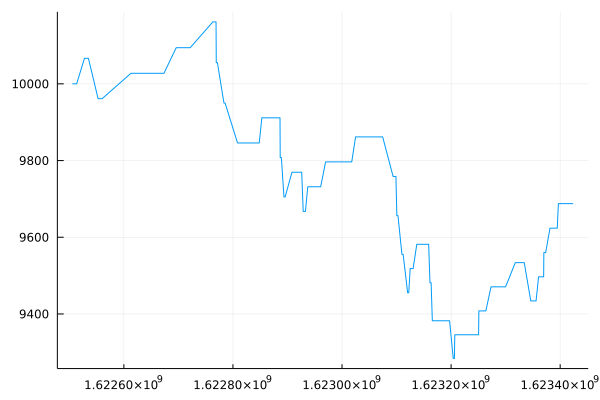

In [28]:
plot(dfoi[].ut,dfoi[].capital,legend=false)

In [13]:
# Dict(:a => 1, :b=>2)["a"]

In [31]:

qfee = 0.001
capital = 10000
risk_per_trade = 0.01

function getEntrySize(capital, risk_per_trade, enter_price, stop_price)
    risk_size = capital * risk_per_trade
    enter_price_with_fee = enter_price*(1+qfee)
    risk_price_range = (enter_price - stop_price)
    qty = risk_size / risk_price_range
end
getEntrySize(capital, risk_per_trade, 100, 110)



-10.0